In [1]:
import numpy as np
from skimage import io
from skimage import draw
from skimage import filters,color
from skimage.morphology import skeletonize,remove_small_objects
import orientation_helpers

from scipy.ndimage import convolve
import matplotlib.pyplot as plt

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


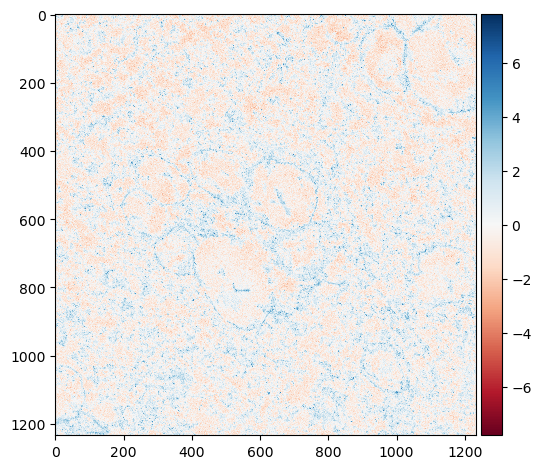

In [6]:
path = '/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/EM_snapshots/img13.tif'
img = np.array(io.imread(path), dtype=np.float32)
img = np.max(img) - img # invert
img = (img - img.mean()) / img.std()
io.imshow(img)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


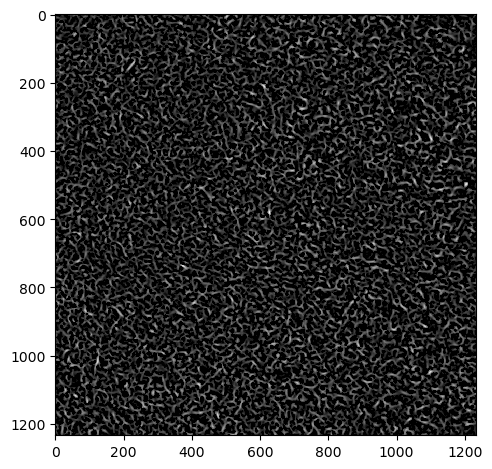

In [25]:
from skimage.filters import meijering
path = '/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/EM_snapshots/img14.tif'
img = np.array(io.imread(path), dtype=np.float32)
img = (img - img.mean()) / img.std()
result = meijering(img,sigmas=[3,4],black_ridges=True)
io.imshow(result)

In [3]:
T = 17000
low_T   = 25
high_T  = 40
kernel_size = 25
diag_lines = []
# Diag lines in y
for i in range(0,kernel_size,3):
    kernel = np.zeros((kernel_size, kernel_size))
    rr, cc = draw.line(i, 0, kernel_size-1-i, kernel_size-1)
    num_ones = len(rr)
    kernel = kernel - num_ones / (kernel_size**2 - num_ones) # Kernel normalization
    kernel[rr, cc] = 1
    img_filtered = convolve(img, kernel)
    
    #img_threshold = img_filtered > T
    img_threshold = filters.apply_hysteresis_threshold(img_filtered, low_T, high_T)
    #img_skeletonized = skeletonize(img_threshold)
    img_diag_lines = remove_small_objects(img_threshold, min_size=20*kernel_size, connectivity=2)
    diag_lines.append(img_diag_lines)

# Diag lines in x  
for i in range(0,kernel_size,3):
    kernel = np.zeros((kernel_size, kernel_size))
    rr, cc = draw.line(0, i, kernel_size-1, kernel_size-1-i)
    num_ones = len(rr)
    kernel = kernel - num_ones / (kernel_size**2 - num_ones) # Kernel normalization
    kernel[rr, cc] = 1
    img_filtered = convolve(img, kernel)
    
    #img_threshold = img_filtered > T
    img_threshold = filters.apply_hysteresis_threshold(img_filtered, low_T, high_T)
    #img_skeletonized = skeletonize(img_threshold)
    img_diag_lines = remove_small_objects(img_threshold, min_size=20*kernel_size, connectivity=2)
    diag_lines.append(img_diag_lines)

result = np.logical_or.reduce(diag_lines)
result = remove_small_objects(result, min_size=100*kernel_size, connectivity=2)
io.imsave(f'./result.tif',result)

/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_9191/3837901366.py:38: UserWarning: ./result.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(f'./result.tif',result)
/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_9191/3837901366.py:38: UserWarning: ./result.tif is a low contrast image
  io.imsave(f'./result.tif',result)


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


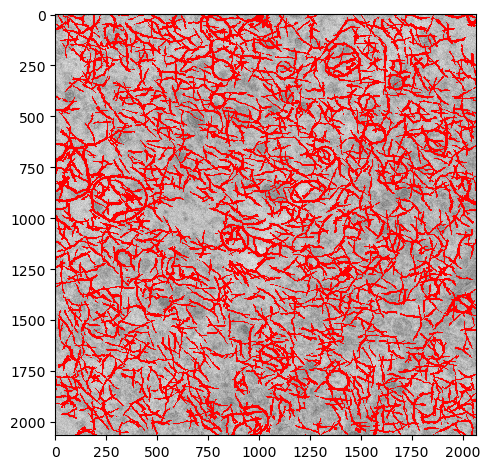

In [25]:
# Draw result on original image
mito_path = '/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/test_images/img5.tif'
mito = np.array(io.imread(mito_path), dtype=np.float32)
mito = mito / np.max(mito)

mito_rgb = color.gray2rgb(mito)
mito_rgb[result,:] = [1,0,0]
io.imshow(mito_rgb)
io.imsave(f'./result_rgb.tif',(255*mito_rgb).astype(np.int8))

In [4]:
# Skeletonize result
skel = skeletonize(result).astype(np.int8)

sigma = 5
orientation, energy, coherence, harris = orientation_helpers.orientation_features(255*skeletonize(result).astype(np.int8), sigma=sigma)
orientation = 180*(orientation + np.pi/2) / np.pi  # Rescale (range [-pi/2,pi/2] -> range [0,180])
orientation = orientation * skel

In [5]:
nbh_detection_kernel = np.array([
    [1,1,1],
    [1,0,1],
    [1,1,1]
])
num_neighbors = convolve(skel,nbh_detection_kernel)*skel
endpoints = np.nonzero(num_neighbors==1)

In [85]:
def find_directed_rectangle(x,y,dx,dy,d_max):
    # Find the directed rectangle in which to search for endpoints to join
    x_vec = np.array([x,y])
    d_vec = np.array([dx,dy]) / np.linalg.norm([dx,dy])
    orth1 = np.array([dy,-dx]) / np.linalg.norm([dx,dy])
    orth2 = np.array([-dy,dx]) / np.linalg.norm([dx,dy])

    x1 = x_vec + orth1 * d_max/2
    x2 = x_vec + orth2 * d_max/2
    x3 = x2 + d_vec * d_max
    x4 = x1 + d_vec * d_max
    
    return [x1[1],x2[1],x3[1],x4[1]],[x1[0],x2[0],x3[0],x4[0]]

In [97]:
Y,X = np.meshgrid(endpoints[0],endpoints[1])
D = np.sqrt((X-X.T)**2 + (Y-Y.T)**2)
d_max = 200 # max distance between 2 pixels which can be linked in pixels

endpoint_id = 0
for y,x in zip(endpoints[0],endpoints[1]):
    nbh_endpoint = skel[y-1:y+2,x-1:x+2]
    # Calculate in which direction this endpoint connected to its neighbor
    nbh_endpoint[1,1] = 0 # Set center of nbh to 0

    dy = (np.nonzero(nbh_endpoint)[0] - 1)[0]
    dx = (np.nonzero(nbh_endpoint)[1] - 1)[0]
    r,c = find_directed_rectangle(x,y,dx,dy,d_max)
    rr,cc = draw.polygon(r,c,shape=skel.shape)

    # Find the directed circle in which to search for endpoints to join
    x_c = int(x - d_max*dx/2)
    y_c = int(y - d_max*dy/2)
    rr, cc = draw.disk((y_c, x_c), d_max/2, shape=skel.shape)
    endpoints_in_circle = np.array([(yp in rr and xp in cc) for (yp,xp) in zip(endpoints[0],endpoints[1])])
    D[endpoint_id, ~endpoints_in_circle] = np.nan
    D[endpoint_id, endpoint_id] = np.nan
    
    endpoint_id = endpoint_id + 1

In [98]:
# Find links and draw them
linked_skel = skel.copy()
links = np.zeros(skel.shape)
to_link = ~np.isnan(D).all(axis=1) # Discard points which have no endpoint in their directed circle
for endpoint_id in np.where(to_link)[0]:
    link_id = np.nanargmin(D[endpoint_id,:])
    try:
        if np.nanargmin(D[link_id,:])==endpoint_id:
            r0,c0 = (endpoints[0][endpoint_id], endpoints[1][endpoint_id])
            r1,c1 = (endpoints[0][link_id], endpoints[1][link_id])
            rr, cc = draw.line(r0, c0, r1, c1)
            linked_skel[rr,cc] = 1
            links[rr,cc] = 1
    except:
        print('Skipped')
io.imsave(f'./linked_skel.tif',linked_skel>0)
io.imsave(f'./links.tif',links>0)

Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped
Skipped


/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_64667/3757824561.py:16: UserWarning: ./linked_skel.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(f'./linked_skel.tif',linked_skel>0)
/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_64667/3757824561.py:16: UserWarning: ./linked_skel.tif is a low contrast image
  io.imsave(f'./linked_skel.tif',linked_skel>0)
/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_64667/3757824561.py:17: UserWarning: ./links.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(f'./links.tif',links>0)
/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_64667/3757824561.py:17: UserWarning: ./links.tif is a low contrast image
  io.imsave(f'./links.tif',links>0)


In [72]:
link_id

1234

In [75]:
D[endpoint_id,:]

array([3325.15322955, 2890.3176296 , 3283.18199313, ..., 1197.00375939,
       1779.00112423,    0.        ])

In [76]:
endpoint_id

1234

In [143]:
np.where(to_link)

(array([   1,    7,    8, ..., 1231, 1232, 1234]),)

In [104]:
np.min(D,axis=1)

array([        inf, 39.66106403,         inf, ..., 70.9365914 ,
               inf, 47.50789408])

In [94]:
a = np.zeros((3,3))
a[1,[True,False,True]] = 1
a

array([[0., 0., 0.],
       [1., 0., 1.],
       [0., 0., 0.]])

In [40]:
io.imsave('endpoints.png',num_neighbors==1)
io.imsave('skeleton.png',skel)

/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_44067/3049088634.py:1: UserWarning: endpoints.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave('endpoints.png',num_neighbors==1)
/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_44067/3049088634.py:1: UserWarning: endpoints.png is a low contrast image
  io.imsave('endpoints.png',num_neighbors==1)
/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_44067/3049088634.py:2: UserWarning: skeleton.png is a low contrast image
  io.imsave('skeleton.png',skel)
Lossy conversion from int8 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


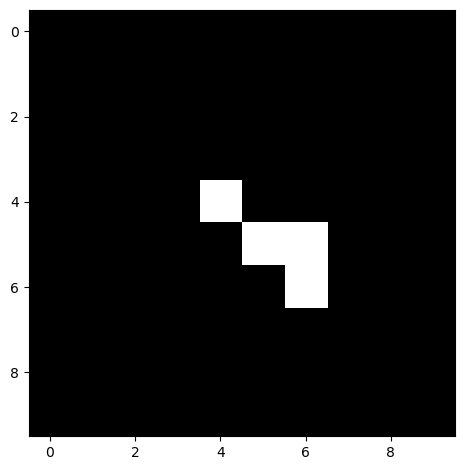

In [27]:
img = np.zeros((10,10))
img[4,4] = 1
img[5,5] = 1
img[5,6] = 1
img[6,6] = 1
io.imshow(img)

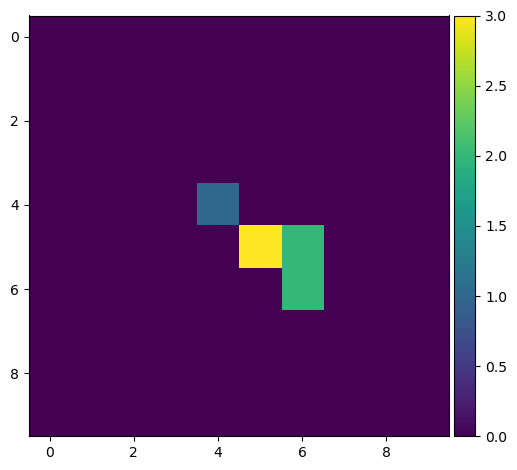

In [28]:
kernel = np.ones((3,3))
kernel[1,1] = 0
io.imshow(convolve(img,kernel)*img)

/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_70546/403457395.py:3: UserWarning: ./diag14.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(f'./diag{i}.tif',img_diag_lines)


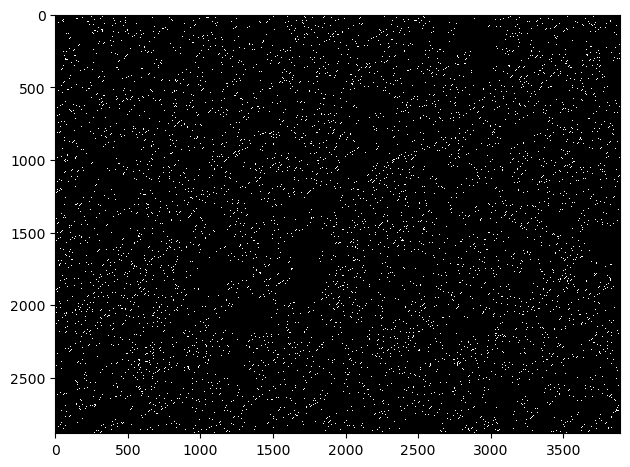

In [77]:
img_diag_lines = remove_small_objects(img_skeletonized, min_size=40, connectivity=2)
io.imshow(img_diag_lines)
io.imsave(f'./diag{i}.tif',img_diag_lines)

In [58]:
io.imsave('./filtered.tif',img_filtered,=100)

TypeError: write() got an unexpected keyword argument 'num_bins'

(array([7.000000e+00, 9.000000e+00, 9.000000e+00, 1.400000e+01,
        1.300000e+01, 1.800000e+01, 2.400000e+01, 2.100000e+01,
        3.400000e+01, 2.600000e+01, 4.400000e+01, 5.300000e+01,
        5.400000e+01, 5.600000e+01, 5.200000e+01, 8.700000e+01,
        1.120000e+02, 1.330000e+02, 1.620000e+02, 1.780000e+02,
        2.210000e+02, 2.620000e+02, 3.350000e+02, 4.430000e+02,
        5.750000e+02, 6.570000e+02, 8.890000e+02, 1.054000e+03,
        1.383000e+03, 1.829000e+03, 2.214000e+03, 2.764000e+03,
        3.647000e+03, 4.423000e+03, 5.308000e+03, 6.707000e+03,
        8.641000e+03, 1.129100e+04, 1.417900e+04, 1.779900e+04,
        2.283300e+04, 2.894800e+04, 3.748300e+04, 4.920200e+04,
        6.513800e+04, 8.758800e+04, 1.183620e+05, 1.592310e+05,
        2.083760e+05, 2.704410e+05, 3.465960e+05, 4.344440e+05,
        5.331690e+05, 6.435990e+05, 7.998750e+05, 1.222981e+06,
        1.486296e+06, 1.008794e+06, 7.593090e+05, 6.262860e+05,
        5.119780e+05, 4.126070e+05, 3.26

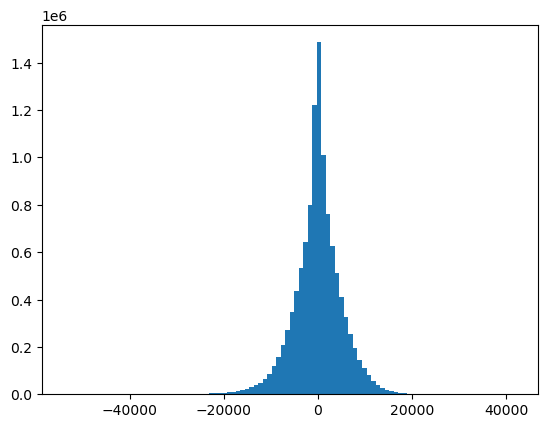

In [59]:
plt.hist(img_filtered.flatten(),bins=100)

In [64]:
np.quantile(img_filtered.flatten(),0.75)

2717.454345703125